In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import time
import model as m
import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("You are using GPU")
else:
    print("You are using CPU")

You are using GPU


In [4]:
class ProcessData(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, 1:].values
        self.labels = dataframe.iloc[:, 0].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'data': torch.tensor(self.data[idx], dtype=torch.float32, device=device),
            'label': torch.tensor(self.labels[idx], dtype=torch.long, device=device)
        }
        return sample

In [5]:
df = pd.read_csv('data_processing/csv_file/landmark_new.csv')
keypoint_dataset = ProcessData(df)

train_size = int(0.8 * len(keypoint_dataset))
val_size = len(keypoint_dataset) - train_size

train_dataset, val_dataset = random_split(keypoint_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Training size:", len(train_dataset))
print("Validation size:", len(val_dataset))

Training size: 12799
Validation size: 3200


In [6]:
model = m.SimpleNN4().to(device)
print("Model's architecture:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's architecture:
fc1.weight 	 torch.Size([256, 126])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([128, 256])
fc2.bias 	 torch.Size([128])
fc3.weight 	 torch.Size([64, 128])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([32, 64])
fc4.bias 	 torch.Size([32])
fc5.weight 	 torch.Size([16, 32])
fc5.bias 	 torch.Size([16])
fc6.weight 	 torch.Size([8, 16])
fc6.bias 	 torch.Size([8])


In [7]:
dataloader = DataLoader(keypoint_dataset, batch_size = 128, shuffle = True)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 100
previous_loss = float('inf')
writer = SummaryWriter()
total_time = 0

In [8]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_correct = 0
    total_samples = 0
    train_loss = 0.0

    for batch in train_loader:
        inputs = batch['data']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    train_accuracy = 100 * total_correct / total_samples
    train_loss /= len(train_loader)
    print(f'Epoch [{epoch}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    writer.add_scalar('Training Loss', train_loss, epoch)
    writer.add_scalar('Training Accuracy', train_accuracy, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

def validate(model, val_loader, criterion, epoch):
    model.eval()
    val_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['data']
            labels = batch['label']

            outputs = model(inputs)
            val_loss += criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            val_total_samples += labels.size(0)
            val_total_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_total_correct / val_total_samples

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    writer.add_scalar('Validation Loss', val_loss, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    return val_accuracy


In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0
start = time.time()
for epoch in range(num_epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)

    if epoch != 0 and epoch % 10 == 0:
        val_accuracy = validate(model, val_loader, criterion, epoch)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_accuracy': best_val_accuracy,
            }
            torch.save(checkpoint, 'models/test.pth')
end = time.time()
total_time = end - start

Epoch [0/100], Training Loss: 1.9437, Training Accuracy: 21.61%
Epoch [1/100], Training Loss: 1.2575, Training Accuracy: 49.04%
Epoch [2/100], Training Loss: 1.0646, Training Accuracy: 55.31%
Epoch [3/100], Training Loss: 0.9440, Training Accuracy: 60.39%
Epoch [4/100], Training Loss: 0.8660, Training Accuracy: 64.90%
Epoch [5/100], Training Loss: 0.7798, Training Accuracy: 69.11%
Epoch [6/100], Training Loss: 0.6658, Training Accuracy: 74.34%
Epoch [7/100], Training Loss: 0.6125, Training Accuracy: 76.40%
Epoch [8/100], Training Loss: 0.5739, Training Accuracy: 78.36%
Epoch [9/100], Training Loss: 0.5340, Training Accuracy: 79.95%
Epoch [10/100], Training Loss: 0.5040, Training Accuracy: 81.31%
Validation Loss: 0.2520, Validation Accuracy: 92.84%
Epoch [11/100], Training Loss: 0.4838, Training Accuracy: 82.48%
Epoch [12/100], Training Loss: 0.4484, Training Accuracy: 83.80%
Epoch [13/100], Training Loss: 0.4250, Training Accuracy: 84.91%
Epoch [14/100], Training Loss: 0.4180, Training

In [15]:
checkpoint_path = "models/test.pth"
checkpoint = torch.load(checkpoint_path)

epoch, best_val_acc = checkpoint['epoch'], checkpoint['best_val_accuracy']

print(f'Time taken: {total_time:.2f}s')
print(f'Best checkpoint from epoch {epoch}')
print(f'Best validation accuracy: {best_val_acc:.2f}%')

Time taken: 165.56s
Best checkpoint from epoch 50
Best validation accuracy: 99.81%


In [17]:
train_losses = torch.from_numpy(np.array(train_losses)).to('cpu')
train_accuracies = torch.from_numpy(np.array(train_accuracies)).to('cpu')
val_losses = torch.from_numpy(np.array(torch.Tensor(val_losses))).to('cpu')
val_accuracies = torch.from_numpy(np.array(val_accuracies)).to('cpu')

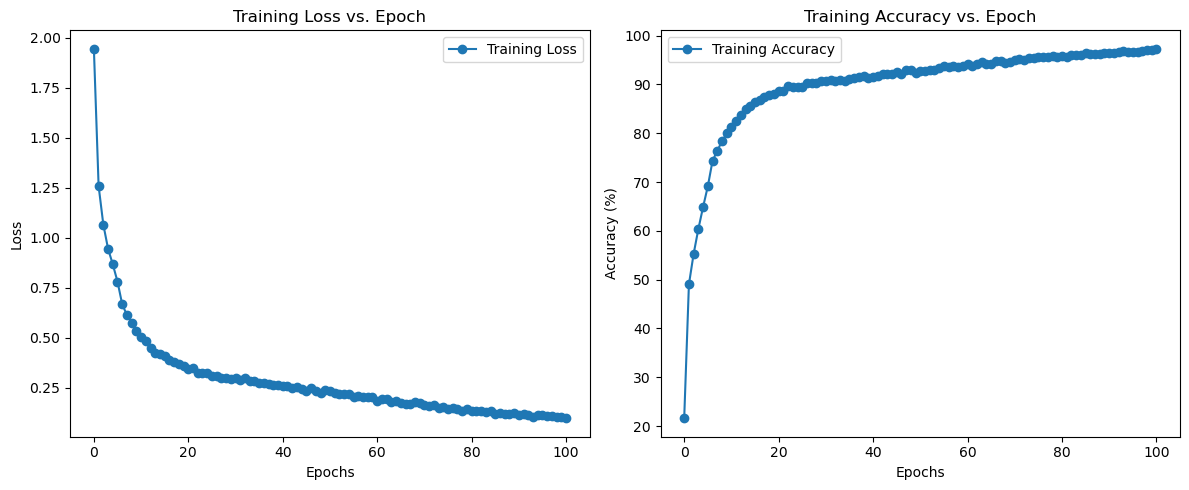

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Epoch')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training Accuracy vs. Epoch')

plt.tight_layout()
plt.show()

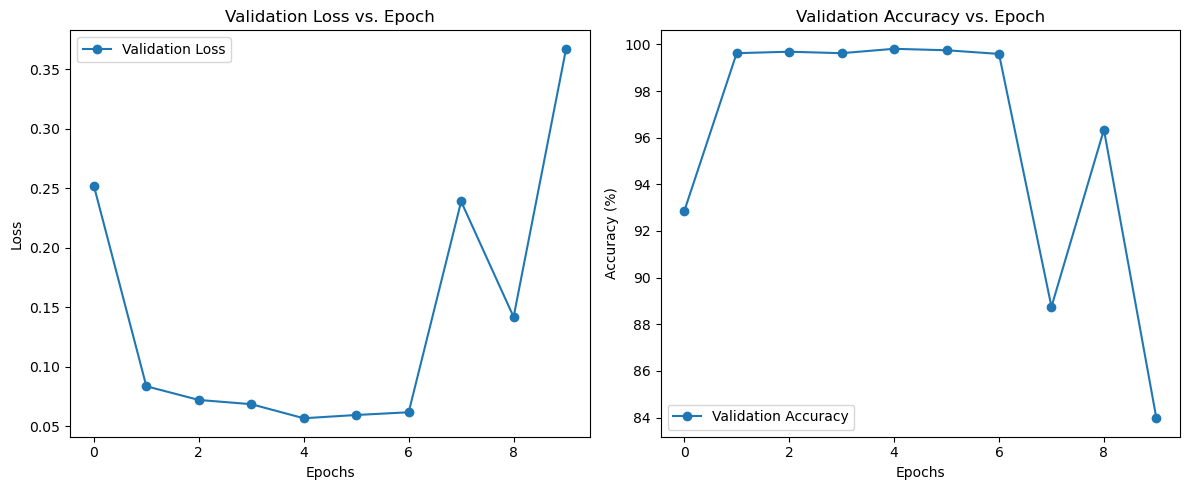

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Validation Loss', marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss vs. Epoch')

# Accuracy subplot for validation
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy vs. Epoch')

# Show the second figure
plt.tight_layout()
plt.show()

Run this in terminal to open tensorboard: tensorboard --logdir=runs
